### Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Preprocessing

## Feature Scaling & File Sorting

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import glob

# input and output directories
root_dir = '../datasets/BB-MAS_Dataset/BB-MAS_Dataset/'
output_base_dir = '../datasets/BB-MAS_Preprocessed/'

# distinguish between accelerometer and gyroscope data
sensor_types = {'Accelerometer': 'accelerometer', 'Gyroscope': 'gyroscope'}

# folders 1 - 117
for i in range(1, 118):
    folder_path = os.path.join(root_dir, str(i))
    csv_files = glob.glob(os.path.join(folder_path, '*_PocketPhone_*.csv'))
    
    if not csv_files:
        continue
    
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        
        # copy the features that aren't being normalized then normalize to be between -1 and 1
        output_df = df[['time']].copy()
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
        for column in ['Xvalue', 'Yvalue', 'Zvalue']:
            scaled_values = scaler.fit_transform(df[[column]])
            output_df[column] = scaled_values
            
        # convert timestamp to panda datetime -> calculate elapsed times -> drop original timestamp
        output_df['time'] = pd.to_datetime(output_df['time'])
        output_df['elapsed_time'] = output_df['time'].diff().dt.total_seconds().fillna(0)
        output_df.drop(columns=['time'], inplace=True)
        
        # determine sensor type for output directory
        for sensor_key, sensor_folder in sensor_types.items():
            if sensor_key in csv_file:
                sensor_output_dir = os.path.join(output_base_dir, sensor_folder)
                break
        else:
            sensor_output_dir = os.path.join(output_base_dir, 'other')
        
        # make sure folders exist and set output file names to be the input file name
        os.makedirs(sensor_output_dir, exist_ok=True)
        output_filename = os.path.basename(csv_file)
        
        # Write to file in the specific sensor type folder
        output_df.to_csv(os.path.join(sensor_output_dir, output_filename), index=False)


## Resizing 

In [3]:
import pandas as pd
import os
import glob

folder_path_accelerometer = '../datasets/BB-MAS_Preprocessed/accelerometer/'
folder_path_gyroscope = '../datasets/BB-MAS_Preprocessed/gyroscope/'

csv_files_accelerometer = glob.glob(os.path.join(folder_path_accelerometer, '*_PocketPhone_*.csv'))
csv_files_gyroscope = glob.glob(os.path.join(folder_path_gyroscope, '*_PocketPhone_*.csv'))
num_rows = 1000000

for csv_file in csv_files_accelerometer:
    df = pd.read_csv(csv_file)
    file_name = os.path.basename(csv_file)
    if df.shape[0] < num_rows:
        num_rows = df.shape[0]
        #print(f'{file_name}: {num_rows}')
    #print(f'{file_name}: {df.shape[0]}')

print("least number of rows in accelerometer folder: ", num_rows)

num_rows = 1000000

for csv_file in csv_files_gyroscope:
    df = pd.read_csv(csv_file)
    file_name = os.path.basename(csv_file)
    if df.shape[0] < num_rows:
        num_rows = df.shape[0]
        #print(f'{file_name}: {num_rows_gyroscope}')
    #print(f'{file_name}: {df.shape[0]}')

print("least number of rows in gyroscope folder: ", num_rows)


least number of rows in accelerometer folder:  17024
least number of rows in gyroscope folder:  17023


## Sequencing

In [ ]:
import numpy as np

sequence_length = 50  # Example sequence length

features = df[['Xvalue', 'Yvalue', 'Zvalue', 'elapsed_time']].values
num_sequences = int(np.floor(features.shape[0] / sequence_length))

X = np.zeros((num_sequences, sequence_length, features.shape[1]))  # Placeholder for input sequences

for i in range(num_sequences):
    X[i] = features[i*sequence_length:(i+1)*sequence_length]

# Assuming y is a numpy array with your labels
y = np.array([your_label_logic_here for _ in range(num_sequences)])  # Adjust label logic as needed


In [20]:
import numpy as np

sequence_length = 100
sequences = []

# loop over the dataset to create sequences
for i in range(0, len(df) - sequence_length, 1):  # overlapping sequences by 1
    # select a sequence of rows from the df
    sequence = df.iloc[i:i + sequence_length]
    
    # add the sequence to our list
    sequences.append(sequence)

sequence_array = np.array(sequences)

# reshape the sequences array to the format expected by the LSTM
# the shape should be (number of sequences, sequence length, number of features)
sequence_array = sequence_array.reshape((len(sequences), sequence_length, df.shape[1]))


NameError: name 'df' is not defined

## Dynamic Time Warping

In [3]:
import pandas as pd
from dtaidistance import dtw
import numpy as np

sensor1_df = pd.read_csv('../datasets/BB-MAS_Preprocessed/accelerometer/1_PocketPhone_Accelerometer_(Samsung_S6).csv')
sensor2_df = pd.read_csv('../datasets/BB-MAS_Preprocessed/gyroscope/1_PocketPhone_Gyroscope_(Samsung_S6).csv')

series1 = sensor1_df['Xvalue'].values
series2 = sensor2_df['Xvalue'].values

# perform DTW
distance, paths = dtw.warping_paths(series1, series2, window=int(max(sensor1_df['elapsed_time'])), psi=2)
best_path = dtw.best_path(paths)

print(f"DTW distance between series: {distance}")


DTW distance between series: 26.20040608905935


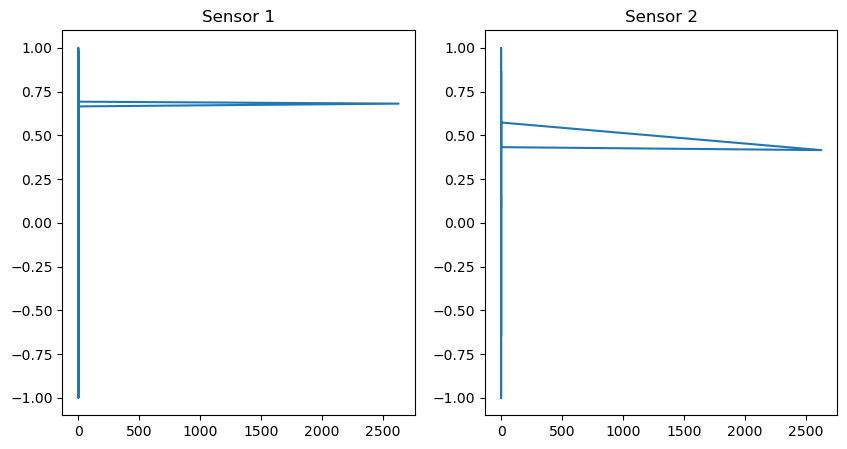

In [5]:
import matplotlib.pyplot as plt

# Visualize the path
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Sensor 1')
plt.plot(sensor1_df['elapsed_time'], series1)
plt.subplot(1, 2, 2)
plt.title('Sensor 2')
plt.plot(sensor2_df['elapsed_time'], series2)
plt.show()


In [7]:
# Assuming 'best_path' is the output from the DTW computation

# Initialize empty lists to store aligned data
aligned_sensor1_data = []
aligned_sensor2_data = []

# Extract the indices from the best path
for index_sensor1, index_sensor2 in best_path:
    aligned_sensor1_data.append(sensor1_df.iloc[index_sensor1].values.tolist())
    aligned_sensor2_data.append(sensor2_df.iloc[index_sensor2].values.tolist())

# Convert the aligned data into DataFrames
aligned_sensor1_df = pd.DataFrame(aligned_sensor1_data, columns=sensor1_df.columns)
aligned_sensor2_df = pd.DataFrame(aligned_sensor2_data, columns=sensor2_df.columns)

# Optionally, reset the index of the resulting DataFrames
aligned_sensor1_df.reset_index(drop=True, inplace=True)
aligned_sensor2_df.reset_index(drop=True, inplace=True)

# Now we can save the aligned dataframes to new CSV files
aligned_sensor1_df.to_csv('aligned_sensor1.csv', index=False)
aligned_sensor2_df.to_csv('aligned_sensor2.csv', index=False)

print("Aligned data has been saved to 'aligned_sensor1.csv' and 'aligned_sensor2.csv'.")


Aligned data has been saved to 'aligned_sensor1.csv' and 'aligned_sensor2.csv'.


In [13]:
import pandas as pd
from scipy.interpolate import interp1d

# Assuming sensor1_df and sensor2_df are already loaded and 'best_path' is computed from DTW

# Get indices for sensor1 and sensor2 from the best path
sensor1_indices = [index_pair[0] for index_pair in best_path]
sensor2_indices = [index_pair[1] for index_pair in best_path]

# Create new DataFrame for aligned data
aligned_data = pd.DataFrame()

# Extract aligned values for sensor1
aligned_data['sensor1_Xvalue'] = sensor1_df.loc[sensor1_indices, 'Xvalue'].values
aligned_data['sensor1_Yvalue'] = sensor1_df.loc[sensor1_indices, 'Yvalue'].values
aligned_data['sensor1_Zvalue'] = sensor1_df.loc[sensor1_indices, 'Zvalue'].values

# Extract aligned values for sensor2
aligned_data['sensor2_Xvalue'] = sensor2_df.loc[sensor2_indices, 'Xvalue'].values
aligned_data['sensor2_Yvalue'] = sensor2_df.loc[sensor2_indices, 'Yvalue'].values
aligned_data['sensor2_Zvalue'] = sensor2_df.loc[sensor2_indices, 'Zvalue'].values

# Since we assume the timestamps after alignment should be identical, we'll use sensor1's timestamps
# as the reference for both sensors.
aligned_data['time'] = sensor1_df.loc[sensor1_indices, 'elapsed_time'].cumsum().values

# Save the aligned data to a new CSV file
aligned_data.to_csv('./aligned_data.csv', index=False)

print("Aligned data has been saved to 'aligned_data.csv'.")


Aligned data has been saved to 'aligned_data.csv'.


In [19]:
from dtaidistance import dtw
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Replace these file paths with your actual file paths
sensor1_filepath = '../datasets/BB-MAS_Preprocessed/small sample/1.csv'
sensor2_filepath = '../datasets/BB-MAS_Preprocessed/small sample/2.csv'

# Load the datasets
sensor1_df = pd.read_csv(sensor1_filepath)
sensor2_df = pd.read_csv(sensor2_filepath)

# Choose an axis for alignment, let's say 'Zvalue', which often carries the strongest signal in gait data
axis = 'Zvalue'
distance, paths = dtw.warping_paths(sensor1_df[axis].values, sensor2_df[axis].values, window=10, use_pruning=True)
best_path = dtw.best_path(paths)

# Use the best path to align all axes
aligned_data = pd.DataFrame()
for axis in ['Xvalue', 'Yvalue', 'Zvalue']:
    aligned_data[f'sensor1_{axis}'] = sensor1_df[axis].iloc[best_path[:, 0]].values
    aligned_data[f'sensor2_{axis}'] = sensor2_df[axis].iloc[best_path[:, 1]].values

# Interpolate the timestamps for sensor1 and sensor2
sensor1_timestamps = sensor1_df['elapsed_time'].cumsum()
sensor2_timestamps = sensor2_df['elapsed_time'].cumsum()

interp_sensor1_time = interp1d(sensor1_timestamps.index, sensor1_timestamps.values, fill_value='extrapolate')
interp_sensor2_time = interp1d(sensor2_timestamps.index, sensor2_timestamps.values, fill_value='extrapolate')

# Apply the interpolation at the DTW-aligned indices
aligned_data['elapsed_time'] = (interp_sensor1_time(best_path[:, 0]) + interp_sensor2_time(best_path[:, 1])) / 2

# Calculate the difference between successive samples to get the time between samples
aligned_data['time_diff'] = aligned_data['elapsed_time'].diff().fillna(method='bfill')

# Save the aligned data to a new CSV file
output_filepath = '/mnt/data/aligned_sensor_data.csv'
aligned_data.to_csv(output_filepath, index=False)
print(f"Aligned data has been saved to '{output_filepath}'.")


TypeError: list indices must be integers or slices, not tuple

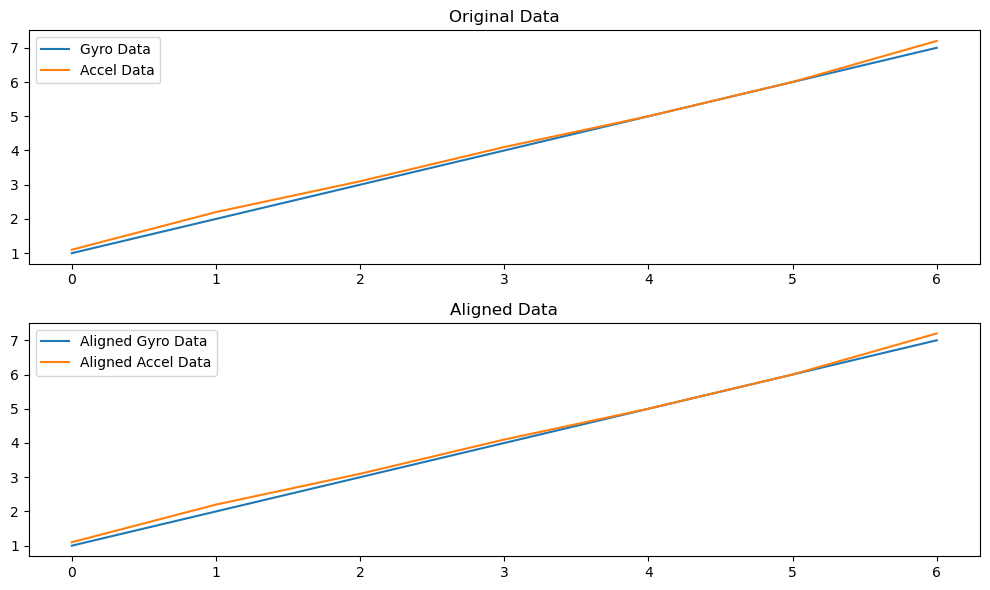

[1.1, 2.2, 3.1, 4.1, 5.0, 6.0, 7.2]


In [2]:
import numpy as np
from dtaidistance import dtw
import matplotlib.pyplot as plt

# Example data (replace these with your actual sensor data)
gyro_data = np.array([1, 2, 3, 4, 5, 6, 7])
accel_data = np.array([1.1, 2.2, 3.1, 4.1, 5, 6, 7.2])

# Compute DTW
distance, paths = dtw.warping_paths(gyro_data, accel_data)
best_path = dtw.best_path(paths)

# Aligned sequences (for visualization)
aligned_gyro_data = [gyro_data[i] for i, j in best_path]
aligned_accel_data = [accel_data[j] for i, j in best_path]

# Plotting original and aligned data
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(gyro_data, label='Gyro Data')
plt.plot(accel_data, label='Accel Data')
plt.title('Original Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(aligned_gyro_data, label='Aligned Gyro Data')
plt.plot(aligned_accel_data, label='Aligned Accel Data')
plt.title('Aligned Data')
plt.legend()

plt.tight_layout()
plt.show()

print(aligned_accel_data)


In [5]:
import pandas as pd
import numpy as np
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

def read_and_align(csv_path1, csv_path2):
    # Load the datasets
    data1 = pd.read_csv(csv_path1)
    data2 = pd.read_csv(csv_path2)
    
    # Assuming columns are 'x', 'y', 'z', 'elapsed_time'
    # You can adjust the column names based on your CSV file format
    series1 = data1['elapsed_time'].to_numpy()
    series2 = data2['elapsed_time'].to_numpy()
    
    # Compute DTW
    distance, paths = dtw.warping_paths(series1, series2)
    best_path = dtw.best_path(paths)
    
    # Align the data based on DTW path
    aligned_data1 = data1.iloc[[i for i, j in best_path]].reset_index(drop=True)
    aligned_data2 = data2.iloc[[j for i, j in best_path]].reset_index(drop=True)
    
    # Optionally, align other columns (x, y, z) here if needed
    
    # Save the aligned datasets to new CSV files
    aligned_data1.to_csv('aligned_data1.csv', index=False)
    aligned_data2.to_csv('aligned_data2.csv', index=False)
    
    print("Aligned data saved to 'aligned_data1.csv' and 'aligned_data2.csv'.")

# Example usage
csv_path1 = '../datasets/BB-MAS_Preprocessed/small_sample/1_PocketPhone_Accelerometer_(Samsung_S6).csv'  # Update this path
csv_path2 = '../datasets/BB-MAS_Preprocessed/small_sample/1_PocketPhone_Gyroscope_(Samsung_S6).csv'  # Update this path

# Call the function with your CSV paths
read_and_align(csv_path1, csv_path2)


Aligned data saved to 'aligned_data1.csv' and 'aligned_data2.csv'.


In [16]:
import pandas as pd
import numpy as np
from dtaidistance import dtw
import os

def read_sensor_data(file_path):
    """Reads sensor data from a CSV file."""
    return pd.read_csv(file_path)

def align_data_using_dtw(series1, series2):
    """Aligns two sequences using DTW."""
    distance, paths = dtw.warping_paths(series1.astype(float), series2.astype(float), window=25, psi=2)
    best_path = dtw.best_path(paths)
    aligned_series1 = np.array([series1[i] for i, _ in best_path])
    aligned_series2 = np.array([series2[j] for _, j in best_path])
    return aligned_series1, aligned_series2

def write_aligned_data_to_csv(aligned_series1, aligned_series2, feature, output_folder="aligned_output"):
    """Writes aligned data for a feature to two separate CSV files."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    df1 = pd.DataFrame(aligned_series1, columns=[feature])
    df1.to_csv(os.path.join(output_folder, f"{feature}_aligned_file1.csv"), index=False)
    
    df2 = pd.DataFrame(aligned_series2, columns=[feature])
    df2.to_csv(os.path.join(output_folder, f"{feature}_aligned_file2.csv"), index=False)

def process_and_align_files(file_path_1, file_path_2):
    data1 = read_sensor_data(file_path_1)
    data2 = read_sensor_data(file_path_2)
    features = ['Xvalue', 'Yvalue', 'Zvalue', 'elapsed_time']
    
    for feature in features:
        series1 = data1[feature].values
        series2 = data2[feature].values
        aligned_series1, aligned_series2 = align_data_using_dtw(series1, series2)
        write_aligned_data_to_csv(aligned_series1, aligned_series2, feature)

# Example usage
file_path_1 = '../datasets/BB-MAS_Preprocessed/small_sample/1_PocketPhone_Accelerometer_(Samsung_S6).csv'  # Fill in your actual file path
file_path_2 = '../datasets/BB-MAS_Preprocessed/small_sample/1_PocketPhone_Gyroscope_(Samsung_S6).csv' # Fill in your actual file path

process_and_align_files(file_path_1, file_path_2)


In [15]:
import pandas as pd
import numpy as np
from dtaidistance import dtw
import os

def read_sensor_data(file_path):
    """Reads sensor data from a CSV file."""
    return pd.read_csv(file_path)

def align_data_using_dtw(series1, series2):
    """Aligns two sequences using DTW."""
    distance, paths = dtw.warping_paths(series1.astype(float), series2.astype(float), window=25, psi=2)
    best_path = dtw.best_path(paths)
    aligned_series1 = np.array([series1[i] for i, _ in best_path])
    aligned_series2 = np.array([series2[j] for _, j in best_path])
    return aligned_series1, aligned_series2

def process_and_align_files(file_path_1, file_path_2, output_path="aligned_data.csv"):
    data1 = read_sensor_data(file_path_1)
    data2 = read_sensor_data(file_path_2)
    features = ['Xvalue', 'Yvalue', 'Zvalue', 'elapsed_time']
    
    aligned_dataframes = []
    for feature in features:
        series1 = data1[feature].values
        series2 = data2[feature].values
        aligned_series1, aligned_series2 = align_data_using_dtw(series1, series2)
        aligned_df = pd.DataFrame({
            f"{feature}_sensor1": aligned_series1,
            f"{feature}_sensor2": aligned_series2
        })
        aligned_dataframes.append(aligned_df)

    # Combine all feature DataFrames into a single DataFrame
    final_aligned_df = pd.concat(aligned_dataframes, axis=1)
    
    # Save the final aligned DataFrame to a CSV file
    final_aligned_df.to_csv(output_path, index=False)

# Example usage
file_path_1 = '../datasets/BB-MAS_Preprocessed/small_sample/1_PocketPhone_Accelerometer_(Samsung_S6).csv'  # Fill in your actual file path
file_path_2 = '../datasets/BB-MAS_Preprocessed/small_sample/1_PocketPhone_Gyroscope_(Samsung_S6).csv' # Fill in your actual file path

process_and_align_files(file_path_1, file_path_2, "aligned_output.csv")


## Scale Verification 

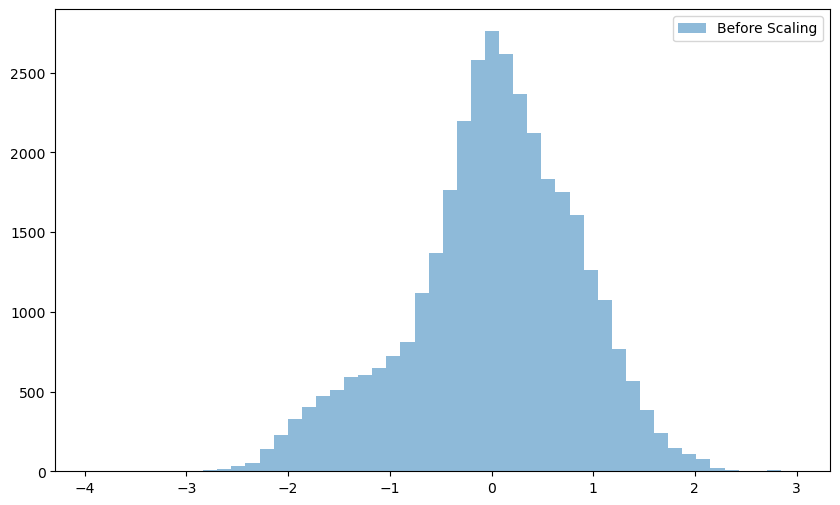

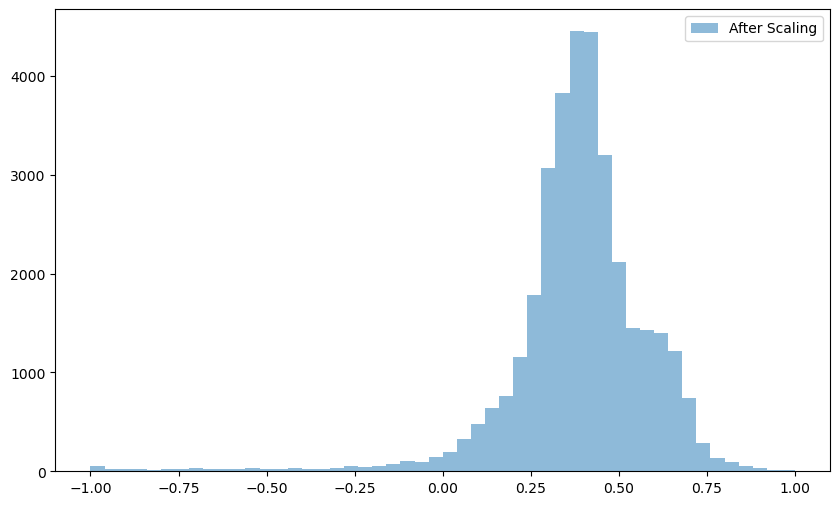

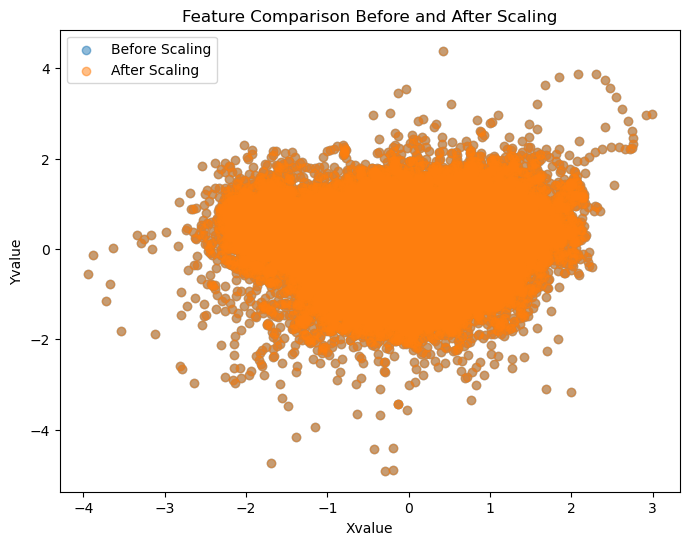

In [35]:
import matplotlib.pyplot as plt

root_dir   = '../datasets/BB-MAS_Dataset/BB-MAS_Dataset/'
output_dir = '../datasets/BB-MAS_Preprocessed/accelerometer/'

folder_path = os.path.join(root_dir, "1")
csv_files = glob.glob(os.path.join(folder_path, '*_PocketPhone_*.csv'))
scaled_files = glob.glob(os.path.join(output_dir, '1_PocketPhone_*.csv'))

df = pd.read_csv(csv_files[0])
X_train = df['Xvalue']
X_scatter = df[['Xvalue', 'Yvalue']]

df_scaled = pd.read_csv(scaled_files[0])
X_train_scaled = df_scaled['Xvalue']
X_scatter_scaled = df[['Xvalue', 'Yvalue']]

# histograms
# before scaling
plt.figure(figsize=(10, 6))
plt.hist(X_train, bins=50, alpha=0.5, label='Before Scaling')
plt.legend()
plt.show()

# after scaling
plt.figure(figsize=(10, 6))
plt.hist(X_train_scaled, bins=50, alpha=0.5, label='After Scaling')
plt.legend()
plt.show()

# scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_scatter['Xvalue'], X_scatter['Yvalue'], alpha=0.5, label='Before Scaling')
plt.scatter(X_scatter_scaled['Xvalue'], X_scatter_scaled['Yvalue'], alpha=0.5, label='After Scaling')
plt.title("Feature Comparison Before and After Scaling")
plt.xlabel("Xvalue")
plt.ylabel("Yvalue")
plt.legend()
plt.show()



# LSTM Creation